<a href="https://colab.research.google.com/github/semant/finance/blob/master/Twitter_Network_PageRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Twitter Dataset through Page Rank to Evaluate Network Strength

> Semant Jain, PhD 
> semant@gmail.com

### Executive Summary
> Understanding interconnectedness between second and third degree connections can reveal insights into supplier or customer relationships. This understanding can be used for leverage in pricing negotiations and diversification of supply chain. While individual business contracts are protected by Non Disclosure Agreements, for this analysis, public Twitter data was used to study interconnectedness between stocks.

> **Analysis:**
> This analysis had three parts:
+ Evaluation of the raw network connectedness between stocks. This identified tickers with most unique connections, tickers with most incoming, and tickers with most outgoing connections.
+ Cumulative Density Function as the number of unique connections increased.
+ Ranking of tickers with weighted incoming connections. This used 'Page Rank' algorithm to evaluate network strength of each ticker.

> **Conclusions:**
> + Cumulative Density Function revealed that while the maximum number of unique connections were as large as 80, 95% of the tickers had 9 unique connections and 97% of the tickers had 16 unique connections. So, limiting examination to 9 - 16 unique connections would be sufficient to capture most of the network effects.
> + Use of Page Rank algorithm in a connected graph weighed the quality of connections while evaluating inbound tweets. So, while raw inbound tweets made Netflix the top ticker, Page Rank revealed Amazon to the true answer. 

### Contents
+ Setting Up
    + Importing libraries
    + Pre-processing data
    + Converting dataframe to boolean index
+ Network Effects
    + Outbound connections from each ticker
    + Building a matrix
    + Cumulative Density Function of unique connections
+ Network Visualization
    + Understanding how tickers reference each other
    + Visualization: First, Second, and Third degree connections
+ Replicating Page Rank
    + Converting twitter database into a matrix
    + Visualization

### Python libraries used
+ Matplotlib
+ Networkx
+ Numpy
+ Pandas
+ Re

# 1. Setting up

### Importing libraries

In [5]:
! pip install networkx

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import re

### Pre-processing data

**Read in tweets**

In [0]:
tweets = pd.read_excel("stockerbot-export.xls")
#print(tweets)

**The most common tickers in tweets**

In [7]:
value_counts = tweets["symbols"].value_counts()
print(value_counts[:10])

NFLX    101
MOMO    100
HON     100
MTB     100
AMAT    100
ES      100
GPS     100
MHK      99
ESS      99
GRPN     99
Name: symbols, dtype: int64


**Deleting combination tickers**

In [8]:
i = value_counts.index.str.contains("-")
print(value_counts.loc[i])

AMZN-GPS         1
FB-GOOGL-GOOG    1
INTC-USB         1
Name: symbols, dtype: int64


**Sample Netflix's tweets**

In [9]:
print(tweets[tweets["symbols"] == "NFLX"]['text'].iloc[0])

Senate wants emergency alerts to go out through Netflix Spotify etc. https://t.co/23yy3whBlc by @grg


**Using regular expressions to identify first 10 NFLX tweets**

In [10]:
i = 0
for x in tweets[tweets["symbols"] == "NFLX"]['text']:
    print(re.findall("\$[a-zA-Z]+", x))
    i += 1
    if i > 9:
        break

[]
['$NFLX']
[]
['$FANG', '$FB', '$AMZN']
['$SPY', '$NFLX', '$UVXY', '$MS', '$CSX', '$ABT', '$UAL']
['$HMNY', '$AMD', '$MU']
['$NFLX']
['$CL']
['$FANG', '$FB', '$AMZN']
['$TWTR', '$FB', '$AAPL', '$NFLX', '$TSLA', '$AMZN', '$GOOGL']


**Using regular expression on the dataframe**

In [11]:
print(tweets[tweets["symbols"] == "NFLX"]['text'].apply(lambda x: re.findall("\$[a-zA-Z]+", x)))

8                                                       []
26391                                              [$NFLX]
26398                                                   []
26411                                  [$FANG, $FB, $AMZN]
26414          [$SPY, $NFLX, $UVXY, $MS, $CSX, $ABT, $UAL]
                               ...                        
28201                                              [$NFLX]
28241                                       [$TSLA, $NFLX]
28274                  [$NFLX, $AMZN, $ADDYY, $AAPL, $DIS]
28290    [$AMZN, $GOOGL, $NFLX, $BA, $TSLA, $TWTR, $SQ,...
28412         [$SQ, $NFLX, $AMZN, $AMD, $TSLA, $AAPL, $GS]
Name: text, Length: 101, dtype: object


### Converting dataframe to boolean index

In [12]:
tweets[tweets["symbols"] == "NFLX"]['text'].apply(lambda x: re.findall("\$[a-zA-Z]+", x)).apply(lambda x: pd.Series(1, index=set(x)))
#print(tweets[tweets["symbols"] == "NFLX"]['text'].apply(lambda x: re.findall("\$[a-zA-Z]+", x)).apply(lambda x: pd.Series(1, index=set(x))))

,$NFLX,$FANG,$FB,$AMZN,$SPY,$MS,$UVXY,$CSX,$UAL,$ABT,$AMD,$HMNY,$MU,$CL,$TSLA,$AAPL,$GOOGL,$TWTR,$JPM,$MSFT,$JD,$ROKU,$BABA,$C,$NXPI,$BAC,$CRM,$V,$ISRG,$ALGN,$NOW,$ILMN,$ABMD,$MA,$LULU,$ADBE,$PANW,$A,$CPAH,$SIRI,...,$BIDU,$SPX,$DJIA,$QQQ,$NVDA,$IBM,$GS,$ebay,$GE,$F,$SBUX,$GGP,$EBAY,$PG,$AAL,$CMCSA,$WMT,$FOXA,$DAL,$IBB,$AABA,$WFC,$XLY,$XLK,$IQ,$RH,$EROS,$IFN,$EPI,$amzn,$nflx,$goog,$aapl,$nwl,$ibm,$nvda,$ADDYY,$WIX,$BA,$SQ
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26391,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26411,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26414,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28201,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28241,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28274,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
28290,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


**Replacing null values with 0**

In [0]:
test = tweets[tweets["symbols"] == "NFLX"]['text'].apply(lambda x: re.findall("\$[a-zA-Z]+", x)).apply(lambda x: pd.Series(1, index=set(x))).fillna(0)
#print(test)

**Normalizing tickers to be uppercase**

In [0]:
test = tweets[tweets["symbols"] == "NFLX"]['text'].apply(lambda x: re.findall("\$[a-zA-Z]+", x)).apply(lambda x: pd.Series(1, index=set(map(str.upper, x)))).fillna(0)
#print(test)

# 2. Network Effects

### Outward connections from each ticker

In [0]:
def find_outward_connections(tweets):
    return tweets['text'].apply(lambda x: re.findall("\$[a-zA-Z]+", x)).apply(lambda x: pd.Series(1, index=set(map(str.upper, x)))).fillna(0).sum()

**Sample outward connections - from Netflix**

In [16]:
print(find_outward_connections(tweets[tweets["symbols"] == "NFLX"]))

$NFLX     69.0
$FANG      9.0
$FB       25.0
$AMZN     33.0
$SPY       3.0
          ... 
$NWL       1.0
$ADDYY     2.0
$WIX       1.0
$BA        1.0
$SQ        2.0
Length: 77, dtype: float64


**Outward connections for all tickers**

In [0]:
connections = tweets.groupby("symbols").apply(find_outward_connections)
#print(connections)

In [0]:
connections = connections.reset_index()
connections.columns = ["Source", "Target", "N"]
#connections

**Replacing $ signs**

In [0]:
connections["Target"] = connections["Target"].str.replace("$","")
#connections

### Building a matrix

In [0]:
connections = connections.pivot("Target", "Source", "N")
#connections

In [0]:
connections = connections.fillna(0)

**Analyzing FAANG stock connections**

In [22]:
FAANG =["FB","AAPL","AMZN","NFLX","GOOG"]
print(connections.reindex(index=FAANG, columns=FAANG).fillna(0))

Source    FB  AAPL  AMZN  NFLX  GOOG
Target                              
FB      50.0   0.0   0.0  25.0  10.0
AAPL     1.0  24.0   0.0  18.0  10.0
AMZN     1.0   0.0   0.0  33.0  14.0
NFLX     0.0   0.0   0.0  69.0   3.0
GOOG     0.0   0.0   0.0   1.0  70.0


**Most referenced stocks (inward connections)**

In [23]:
print(connections.sum(axis=1).sort_values(ascending=False))

Target
NFLX     672.0
AMZN     533.0
SPY      454.0
FB       454.0
MSFT     414.0
         ...  
CRE        1.0
NATI       1.0
CRES       1.0
CRESY      1.0
ZZC        1.0
Length: 5171, dtype: float64


In [0]:
df_p = connections.sum(axis=1).sort_values(ascending=False)

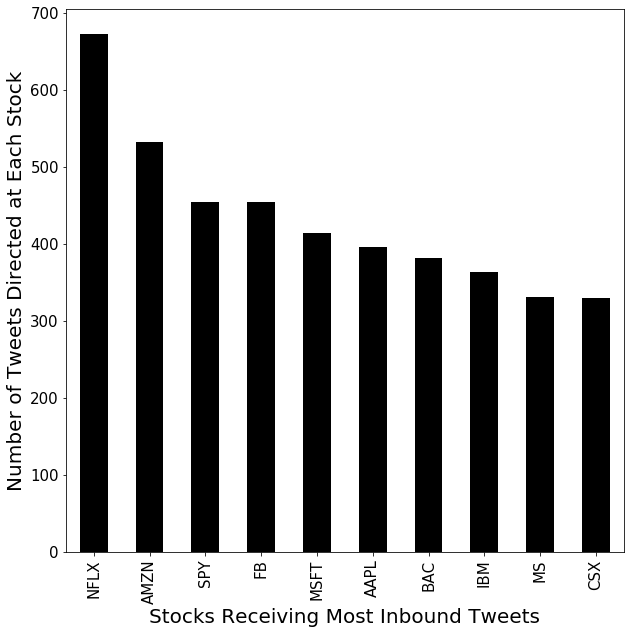

In [25]:
plt.figure(figsize = (10,10))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
df_p[:10].plot(kind = 'bar', color = 'black')
plt.xlabel("Stocks Receiving Most Inbound Tweets", fontsize = 20)
plt.ylabel("Number of Tweets Directed at Each Stock", fontsize = 20)
plt.savefig('EDHEC_03_01_MostInboundTweets.jpeg')
#plt.title("Stocks Ranked by Most Inbound Tweet Connections", fontsize = 20)
plt.show()

**Most referencing stocks (outward connections)**

In [26]:
print(connections.sum().sort_values(ascending=False))

Source
SQQQ      1353.0
CTAS       920.0
ESS        890.0
HCP        872.0
ERIC       762.0
           ...  
TSS         12.0
CMS         12.0
M            2.0
GS           1.0
ticker       1.0
Length: 448, dtype: float64


In [0]:
#print(connections.stack())

**Unique connections**

In [28]:
print((connections.stack() > 0).sum())

23047


### Cumulative Density Function (CDF) of Unique Connections

In [0]:
unique_connections = connections.stack()
unique_connections = unique_connections[unique_connections > 0]
unique_connections = unique_connections.sort_values()
cdf = pd.Series(list(range(1,len(unique_connections)+1)), index=unique_connections)
#print(cdf)

In [0]:
cdf = cdf / len(unique_connections)
#cdf

In [0]:
cdf = cdf.groupby(cdf.index).max()
#print(cdf)

**Visualization of CDF**

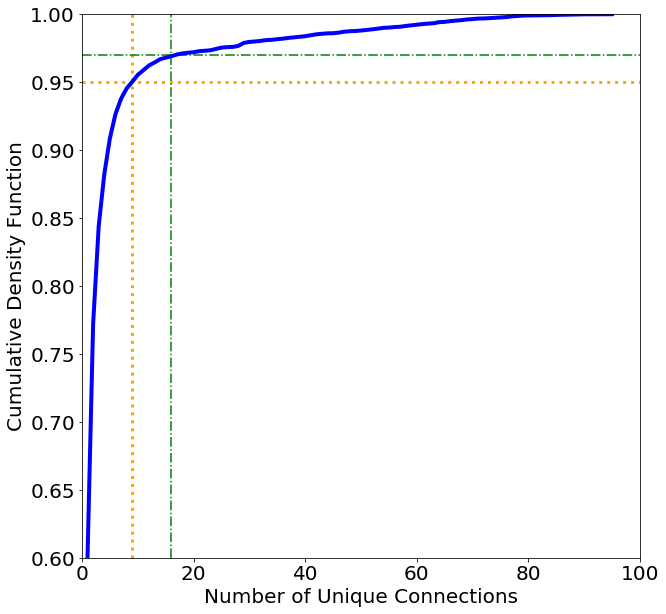

In [32]:
plt.figure(figsize = (10,10))
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Number of Unique Connections", fontsize = 20)
plt.ylabel("Cumulative Density Function", fontsize = 20)

plt.axhline(0.95, ls=":", color = "orange", linewidth = 3)
plt.axvline(9, ls=":", color="orange", label = "95% CDF", linewidth = 3)

plt.axhline(0.97, ls="-.", color = "green")
plt.axvline(16, ls="-.", color="green", label = "97% CDF")

cdf.plot(kind='line', color = "blue", linewidth = 4)
plt.xlim(0, 100)
plt.ylim(0.60, 1.00)

plt.savefig('EDHEC_03_02_CDF.jpeg')
plt.show()

---
# 2. Network Visualization
### Understanding how tickers reference each other

**Building Network for Netflix**

In [0]:
nflx_target = connections.loc["NFLX"]
nflx_target = nflx_target.sort_values(ascending=False)
#print(nflx_target.head(6))

**First Level Connections**

In [0]:
first_level = nflx_target.head(6).reset_index()
first_level.columns = ["Source", "Connections"]
first_level["Target"] = "NFLX"
#print(first_level)

**Second level Connections: Limit 6**

In [0]:
second_level = []
for x in first_level["Source"]:
    if x == "NFLX":
        pass
    else:
        target = connections.loc[x]
        target = target.sort_values(ascending=False)
        target = target[target>0].head(6)
        target = target.reset_index()
        target.columns = ["Source", "Connections"]
        target["Target"] = x
        second_level.append(target)
second_level = pd.concat(second_level)
#print(second_level)

**Third Level Connections**

In [0]:
third_level = []
for x in second_level["Source"]:
    if x in first_level["Target"] or x in second_level["Target"]:
        pass
    else:
        target = connections.loc[x]
        target = target.sort_values(ascending=False)
        target = target[target>0].head(6)
        target = target.reset_index()
        target.columns = ["Source", "Connections"]
        target["Target"] = x
        third_level.append(target)
third_level = pd.concat(third_level)
#print(third_level)

### Visualization

**Graph Initialiation**

In [0]:
G = nx.Graph()
#Add a node
G.add_node("NFLX")
#Draw and show the graph
#nx.draw(G, with_labels=True, font_weight='bold')
#plt.show()

**First and Second Degree Nodes**

In [0]:
G = nx.Graph()
for node in set(list(first_level["Target"]) + list(first_level["Source"])):
    G.add_node(node)
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()

**Adding Edges**

In [0]:
G = nx.Graph()
for node in set(list(first_level["Target"]) + list(first_level["Source"])):
    G.add_node(node)
#An example of how to draw connections between nodes
G.add_edges_from([["NFLX", "HON"], ["NFLX", "SIRI"]])
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()

**Graph: First Degree Connections with Edges**

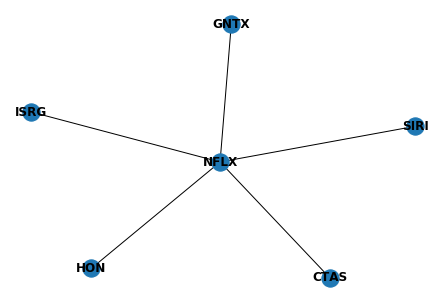

In [40]:
G = nx.Graph()
for node in set(list(first_level["Target"]) + list(first_level["Source"])):
    G.add_node(node)
G.add_edges_from(first_level[["Source", "Target"]].values)
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

**Graph: Second Degree Connections with Edges**

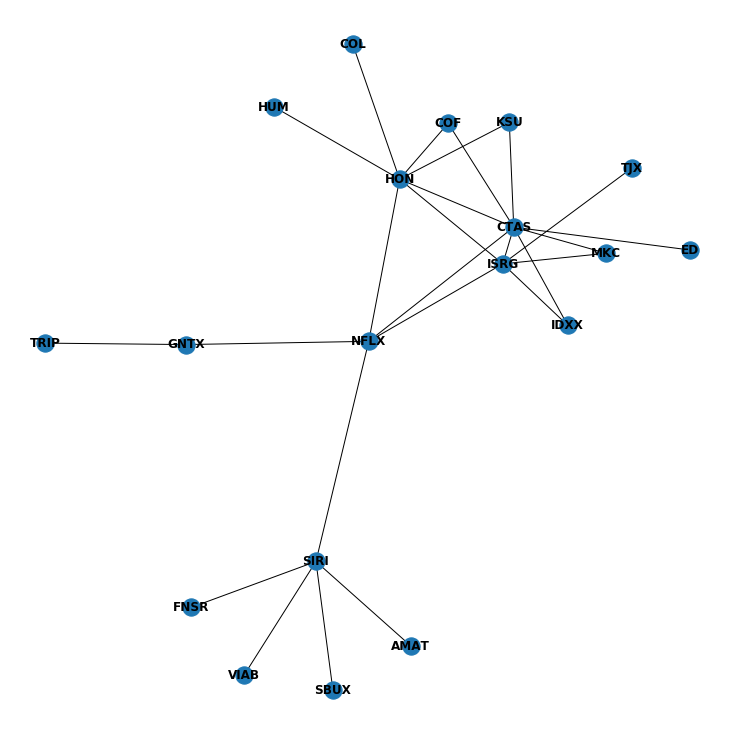

In [41]:
plt.figure(figsize = (10,10))

G = nx.Graph()
#Create a dataframe which holds first level and second level
graph_nodes = pd.concat([first_level, second_level])
for node in set(list(graph_nodes["Target"]) + list(graph_nodes["Source"])):
    G.add_node(node)
G.add_edges_from(graph_nodes[["Source", "Target"]].values)
nx.draw(G, with_labels=True, font_weight='bold')

plt.savefig('EDHEC_03_02_Network.jpeg')
plt.show()

**Graph: Third Degree Connections with Edges**

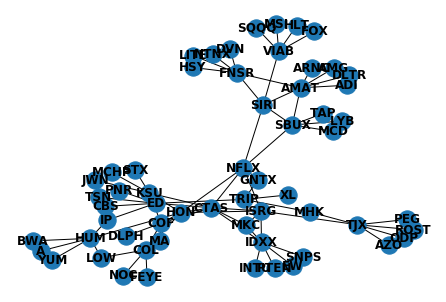

In [42]:
G = nx.Graph()
graph_nodes = pd.concat([first_level, second_level, third_level])
for node in set(list(graph_nodes["Target"]) + list(graph_nodes["Source"])):
    G.add_node(node)
G.add_edges_from(graph_nodes[["Source", "Target"]].values)
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

---

# 3. Replicating PageRank

+ Network Visualization just used raw frequency to compute first, second, and third degree connections.
+ Here, the quality of the incoming connections is also weighed to determine the overall ranking

### Converting Twitter database into a matrix

In [0]:
#print(connections)

#Let's turn it into a binary matrix
connections_binary = connections.copy()
connections_binary[connections_binary > 0] = 1

#Reindex so that all index and column values are present
i = connections_binary.index.union(connections_binary.columns)
connections_binary = connections_binary.reindex(index=i, columns=i).fillna(0)

**Eliminating diagonal elements**

In [0]:
#First grab the indices present in the matrix
rows, cols = np.indices((len(connections_binary.columns), len(connections_binary.columns)))

#Diagonal elements indices
#print(rows == cols)

mask = rows == cols
connections_binary = connections_binary.mask(mask).fillna(0)
#print(connections_binary)

**Normalizing the columns to sum to 1**

In [45]:
connections_binary = (connections_binary / connections_binary.sum()).fillna(0)
print(connections_binary)

          A   AA  AABA  AAC  AAGC  AAL  ...  ZUO  ZYB  ZYME  ZYNE  ZZC  ticker
A       0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0   0.0   0.0  0.0     0.0
AA      0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0   0.0   0.0  0.0     0.0
AABA    0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0   0.0   0.0  0.0     0.0
AAC     0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0   0.0   0.0  0.0     0.0
AAGC    0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0   0.0   0.0  0.0     0.0
...     ...  ...   ...  ...   ...  ...  ...  ...  ...   ...   ...  ...     ...
ZYB     0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0   0.0   0.0  0.0     0.0
ZYME    0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0   0.0   0.0  0.0     0.0
ZYNE    0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0   0.0   0.0  0.0     0.0
ZZC     0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0   0.0   0.0  0.0     0.0
ticker  0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0   0.0   0.0  0.0     0.0

[5172 rows x 5172 columns]


**Setting up Page Rank Vector**

In [46]:
page_rank_vector = pd.Series(1/len(connections_binary), index = connections_binary.index)

#Start with a dummy old value
page_rank_vector_old = pd.Series(100, index = connections_binary.index)
damping_factor = .85

i = 0
while np.linalg.norm(page_rank_vector - page_rank_vector_old, 2) > 1.0e-6:
    page_rank_vector_old = page_rank_vector
    page_rank_vector = (1-damping_factor)/len(connections_binary) + damping_factor * connections_binary.dot(page_rank_vector)
    i+=1
print(page_rank_vector.sort_values(ascending=False))
print("Took {} loops to converge".format(i))

AMZN      0.000251
IBM       0.000211
LINK      0.000204
MSFT      0.000203
NFLX      0.000152
            ...   
LUK       0.000029
RHI       0.000029
COO       0.000029
ALLE      0.000029
ticker    0.000029
Length: 5172, dtype: float64
Took 9 loops to converge


In [0]:
df2 = page_rank_vector.sort_values(ascending=False)

### Visualization

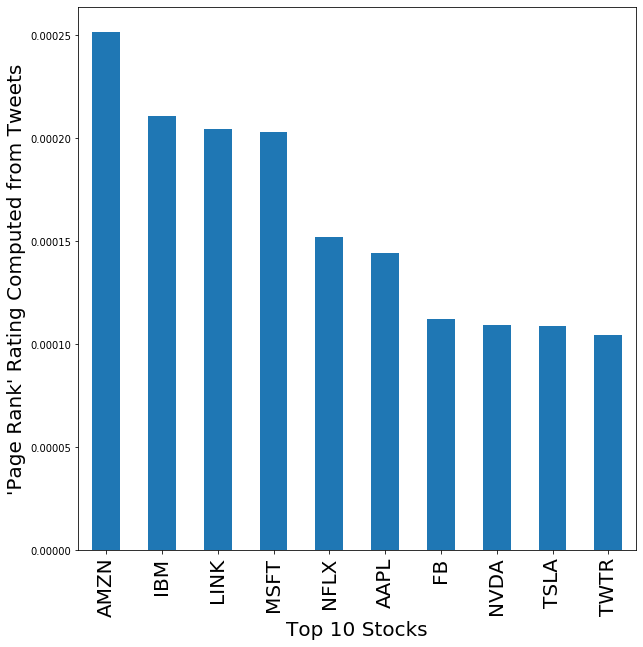

In [48]:
plt.figure(figsize = (10,10))
plt.xticks(fontsize = 20)
plt.ylabel("'Page Rank' Rating Computed from Tweets", fontsize = 20)
plt.xlabel("Top 10 Stocks", fontsize = 20)
#plt.title("Stocks Ranked by 'Page Rank' Algorithm Computed From Tweets", fontsize = 20)
df2[:10].plot(kind = 'bar')
plt.yticks(fontsize = 10, ticks = None )
plt.savefig('EDHEC_03_03_PageRankResults.jpeg')
plt.show()